병합데이터셋-v5: backtranslation(한글->영어->한글)을 통한 데이터 증강

In [4]:
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'
!pip install sentencepiece
!pip install transformers
!pip install torch

!pip install mxnet
!pip install gluonnlp pandas tqdm

# 라이브러리 불러오기
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import gluonnlp as nlp

#kobert
from kobert_tokenizer import KoBERTTokenizer

# transformers
from transformers import BertModel
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

  Cloning https://github.com/SKTBrain/KoBERT.git to /tmp/pip-install-ertrv40q/kobert-tokenizer_14b66f2cdb4a4d1c90958faea6e0ecae
  Running command git clone --filter=blob:none --quiet https://github.com/SKTBrain/KoBERT.git /tmp/pip-install-ertrv40q/kobert-tokenizer_14b66f2cdb4a4d1c90958faea6e0ecae
  Resolved https://github.com/SKTBrain/KoBERT.git to commit 47a69af87928fc24e20f571fe10c3cc9dd9af9a3
  Preparing metadata (setup.py) ... done
  Created wheel for kobert_tokenizer: filename=kobert_tokenizer-0.1-py3-none-any.whl size=4632 sha256=a4a54d4eba56065264f32a96d09a745498c0bf3af290b8bf162ab53e93c0bcc9
  Stored in directory: /tmp/pip-ephem-wheel-cache-prlcw5tc/wheels/e9/1a/3f/a864970e8a169c176befa3c4a1e07aa612f69195907a4045fe
Successfully built kobert_tokenizer
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 36.9 MB/s eta

In [ ]:
import pandas as pd

train_set = pd.read_csv('data/병합데이터셋-v5-bt.csv', index_col=0)

train_set = train_set.dropna()
train_set = train_set.reset_index(drop=True)

# 감정을 정수 라벨로 변경
emotions = {'행복': 0, '불안': 1, '놀람': 2, '슬픔': 3, '분노': 4, '중립': 5 }
train_set['emotion'] = train_set.emotion.map(emotions)

# 데이터 프레임 셔플
train_set = train_set.sample(frac=1).reset_index(drop=True)
train_set.shape

# GPU 사용시 필요
device = torch.device("cuda")

tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
bertmodel = BertModel.from_pretrained('skt/kobert-base-v1', return_dict=False)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(tokenizer.vocab_file, padding_token='[PAD]')
tok = tokenizer.tokenize

# Setting parameters
max_len = 64
batch_size = 32 #베이스라인 64
warmup_ratio = 0.1
num_epochs = 7  # 에포크 횟수
max_grad_norm = 1
log_interval = 200
learning_rate = 1e-5

# 모델에 사용되는 데이터셋 클래스 정의
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer,vocab, max_len,
                 pad, pair):

        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len,vocab=vocab, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(float(i[label_idx])) for i in dataset]         # self.labels = [np.int32(i[label_idx]) for i in dataset] 이꺼 변경



    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

# 감성 분류 모델 정의
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=6,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate

        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)

    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)

        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

# 모델 학습에 사용할 데이터셋을 [data, label] 배열로 피팅
train_set_data = [[i, str(j)] for i, j in zip(train_set['sentence'], train_set['emotion'])]

# sklearn 의 train_test_split 모듈-> 4:1로 학습&검증 데이터를 분류
train_set_data, test_set_data = train_test_split(train_set_data, test_size = 0.2, random_state=0)

# 데이터셋을 Bert모델에 입력할 수 있게 변환
train_set_data = BERTDataset(train_set_data, 0, 1, tok, vocab, max_len, True, False)
test_set_data = BERTDataset(test_set_data, 0, 1, tok, vocab, max_len, True, False)

# 배치데이터셋 생성
train_dataloader = torch.utils.data.DataLoader(train_set_data, batch_size=batch_size, num_workers=0)    # num_workers: 데이터 로딩할때 쓰는 프로세스 수(로딩속도)
test_dataloader = torch.utils.data.DataLoader(test_set_data, batch_size=batch_size, num_workers=0)

# 모델 선언
model = BERTClassifier(bertmodel, dr_rate=0.5).to(device)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()
t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

# 정확도 계산
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

# 예측 반환
def predict(sentence):
    dataset = [[sentence, '0']]
    test = BERTDataset(dataset, 0, 1, tok, vocab, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=batch_size, num_workers=0)  #로컬에서는 디폴트(0)으로 수정
    model.eval()
    answer = 0
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        for logits in out:
            logits = logits.detach().cpu().numpy()
            answer = np.argmax(logits)
    return answer

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
train_accuarcy, test_accuarcy = [], []

for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    train_accuarcy.append(train_acc / (batch_id+1))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(test_dataloader)):   # 아까 만든 테스트 배치 데이터 - 정확도 측정
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    test_accuarcy.append(test_acc / (batch_id+1))
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))
    torch.save(model, 'model/kobert-v9_epoch{}.pt'.format(e+1)) # 에폭마다 모델 저장

train_accuarcy, test_accuarcy

  0%|          | 0/3689 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 1.7999616861343384 train acc 0.25
epoch 1 batch id 201 loss 1.725932240486145 train acc 0.1881218905472637
epoch 1 batch id 401 loss 1.6300026178359985 train acc 0.2203865336658354
epoch 1 batch id 601 loss 1.5221643447875977 train acc 0.26112728785357736
epoch 1 batch id 801 loss 1.2349188327789307 train acc 0.3086376404494382
epoch 1 batch id 1001 loss 1.385638952255249 train acc 0.3491820679320679
epoch 1 batch id 1201 loss 1.1860133409500122 train acc 0.3797876769358868
epoch 1 batch id 1401 loss 1.1145671606063843 train acc 0.40625
epoch 1 batch id 1601 loss 1.5449868440628052 train acc 0.42754528419737664
epoch 1 batch id 1801 loss 1.5040473937988281 train acc 0.44555108273181565
epoch 1 batch id 2001 loss 0.8802046775817871 train acc 0.4616285607196402
epoch 1 batch id 2201 loss 1.0483064651489258 train acc 0.4769139027714675
epoch 1 batch id 2401 loss 0.7457072138786316 train acc 0.48973084131611827
epoch 1 batch id 2601 loss 1.0607560873031616 train acc

  0%|          | 0/923 [00:00<?, ?it/s]

epoch 1 test acc 0.6722982123510293


  0%|          | 0/3689 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 0.9089002013206482 train acc 0.59375
epoch 2 batch id 201 loss 0.8770117163658142 train acc 0.6602922885572139
epoch 2 batch id 401 loss 1.0048145055770874 train acc 0.6625623441396509
epoch 2 batch id 601 loss 0.528467059135437 train acc 0.6614496672212978
epoch 2 batch id 801 loss 0.9888059496879578 train acc 0.6598782771535581
epoch 2 batch id 1001 loss 0.7184544205665588 train acc 0.6637112887112887
epoch 2 batch id 1201 loss 0.9754796028137207 train acc 0.6657212739383847
epoch 2 batch id 1401 loss 0.6822404861450195 train acc 0.667848857958601
epoch 2 batch id 1601 loss 1.4262032508850098 train acc 0.6688593066833229
epoch 2 batch id 1801 loss 1.0865001678466797 train acc 0.6696279844530816
epoch 2 batch id 2001 loss 0.6765258312225342 train acc 0.6711019490254873
epoch 2 batch id 2201 loss 0.9031979441642761 train acc 0.6735006815084053
epoch 2 batch id 2401 loss 0.6563957929611206 train acc 0.6749140982923781
epoch 2 batch id 2601 loss 0.8235802054405212

  0%|          | 0/923 [00:00<?, ?it/s]

epoch 2 test acc 0.6938651137594799


  0%|          | 0/3689 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 0.7830327153205872 train acc 0.71875
epoch 3 batch id 201 loss 0.702874481678009 train acc 0.7069340796019901
epoch 3 batch id 401 loss 0.8964571952819824 train acc 0.7051901496259352
epoch 3 batch id 601 loss 0.4725668430328369 train acc 0.7056988352745425
epoch 3 batch id 801 loss 1.0856231451034546 train acc 0.7031054931335831
epoch 3 batch id 1001 loss 0.5799542665481567 train acc 0.7055756743256744
epoch 3 batch id 1201 loss 0.8147823810577393 train acc 0.7072231473771857
epoch 3 batch id 1401 loss 0.6308228969573975 train acc 0.7087125267665952
epoch 3 batch id 1601 loss 1.1819053888320923 train acc 0.7091661461586508
epoch 3 batch id 1801 loss 1.0288112163543701 train acc 0.7096057745696835
epoch 3 batch id 2001 loss 0.6968345046043396 train acc 0.7108789355322339
epoch 3 batch id 2201 loss 0.8104745745658875 train acc 0.7129003861880964
epoch 3 batch id 2401 loss 0.6554853320121765 train acc 0.7140774677217826
epoch 3 batch id 2601 loss 0.758052945137023

  0%|          | 0/923 [00:00<?, ?it/s]

epoch 3 test acc 0.6987066630552546


  0%|          | 0/3689 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 0.7814083695411682 train acc 0.75
epoch 4 batch id 201 loss 0.6731406450271606 train acc 0.7414490049751243
epoch 4 batch id 401 loss 0.7117723226547241 train acc 0.7425187032418953
epoch 4 batch id 601 loss 0.37276050448417664 train acc 0.7389247088186356
epoch 4 batch id 801 loss 0.8934367299079895 train acc 0.7360330836454432
epoch 4 batch id 1001 loss 0.48121753334999084 train acc 0.7390734265734266
epoch 4 batch id 1201 loss 0.7603123784065247 train acc 0.7398261865112407
epoch 4 batch id 1401 loss 0.556817889213562 train acc 0.7409885795860099
epoch 4 batch id 1601 loss 1.181864857673645 train acc 0.7407284509681449
epoch 4 batch id 1801 loss 0.8984227776527405 train acc 0.7410292892837312
epoch 4 batch id 2001 loss 0.6832150220870972 train acc 0.7421133183408296
epoch 4 batch id 2201 loss 0.7061731219291687 train acc 0.7444201499318491
epoch 4 batch id 2401 loss 0.5470131635665894 train acc 0.7449760516451479
epoch 4 batch id 2601 loss 0.7735873460769653 

  0%|          | 0/923 [00:00<?, ?it/s]

epoch 4 test acc 0.7019907908992417


  0%|          | 0/3689 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.716416597366333 train acc 0.75
epoch 5 batch id 201 loss 0.6698712706565857 train acc 0.7678793532338308
epoch 5 batch id 401 loss 0.734032154083252 train acc 0.7685473815461347
epoch 5 batch id 601 loss 0.3140842318534851 train acc 0.7659109816971714
epoch 5 batch id 801 loss 0.887663722038269 train acc 0.7629135455680399
epoch 5 batch id 1001 loss 0.3966001868247986 train acc 0.7657967032967034
epoch 5 batch id 1201 loss 0.7694513201713562 train acc 0.7662104496253123
epoch 5 batch id 1401 loss 0.4146268665790558 train acc 0.7672644539614561
epoch 5 batch id 1601 loss 1.1741790771484375 train acc 0.7670986883198001
epoch 5 batch id 1801 loss 0.8031587600708008 train acc 0.7674035258189894
epoch 5 batch id 2001 loss 0.5927572250366211 train acc 0.7686313093453273
epoch 5 batch id 2201 loss 0.5753135085105896 train acc 0.7704736483416629
epoch 5 batch id 2401 loss 0.42289087176322937 train acc 0.7707335485214494
epoch 5 batch id 2601 loss 0.5634285807609558 tr

  0%|          | 0/923 [00:00<?, ?it/s]

epoch 5 test acc 0.6980633802816901


  0%|          | 0/3689 [00:00<?, ?it/s]

epoch 6 batch id 1 loss 0.7208852767944336 train acc 0.71875
epoch 6 batch id 201 loss 0.5532852411270142 train acc 0.7852922885572139
epoch 6 batch id 401 loss 0.6210533976554871 train acc 0.7891988778054863
epoch 6 batch id 601 loss 0.2886757552623749 train acc 0.7868136439267887
epoch 6 batch id 801 loss 0.7509282827377319 train acc 0.7840589887640449
epoch 6 batch id 1001 loss 0.31125542521476746 train acc 0.7864323176823177
epoch 6 batch id 1201 loss 0.5976042151451111 train acc 0.7865060366361366
epoch 6 batch id 1401 loss 0.41346707940101624 train acc 0.7872724839400428
epoch 6 batch id 1601 loss 1.1031816005706787 train acc 0.7868910056214866
epoch 6 batch id 1801 loss 0.9225209951400757 train acc 0.7867504164353137
epoch 6 batch id 2001 loss 0.49451664090156555 train acc 0.787543728135932
epoch 6 batch id 2201 loss 0.5188198685646057 train acc 0.7886188096319855
epoch 6 batch id 2401 loss 0.38273653388023376 train acc 0.7886167221990837
epoch 6 batch id 2601 loss 0.62612348794

  0%|          | 0/923 [00:00<?, ?it/s]

epoch 6 test acc 0.6969460996749729


  0%|          | 0/3689 [00:00<?, ?it/s]

epoch 7 batch id 1 loss 0.8053227066993713 train acc 0.65625
epoch 7 batch id 201 loss 0.6959167718887329 train acc 0.7975746268656716
epoch 7 batch id 401 loss 0.7638635635375977 train acc 0.8012780548628429
epoch 7 batch id 601 loss 0.231167733669281 train acc 0.7982529118136439
epoch 7 batch id 801 loss 0.761433482170105 train acc 0.7968164794007491
epoch 7 batch id 1001 loss 0.2762502133846283 train acc 0.7986388611388612
epoch 7 batch id 1201 loss 0.6850934624671936 train acc 0.799151748542881
epoch 7 batch id 1401 loss 0.42299017310142517 train acc 0.799362062812277
epoch 7 batch id 1601 loss 0.9768654704093933 train acc 0.7987976264834479
epoch 7 batch id 1801 loss 0.8106615543365479 train acc 0.797994169905608
epoch 7 batch id 2001 loss 0.6244412660598755 train acc 0.7988974262868566
epoch 7 batch id 2201 loss 0.517919659614563 train acc 0.8001476601544752
epoch 7 batch id 2401 loss 0.3300885856151581 train acc 0.7998229904206581
epoch 7 batch id 2601 loss 0.6727506518363953 tr

  0%|          | 0/923 [00:00<?, ?it/s]

epoch 7 test acc 0.6971153846153846


([0.5455407969639469,
  0.683908240715641,
  0.721071089726213,
  0.7513384386012469,
  0.7758454188126863,
  0.7920252778530767,
  0.8012757522363784],
 [0.6722982123510293,
  0.6938651137594799,
  0.6987066630552546,
  0.7019907908992417,
  0.6980633802816901,
  0.6969460996749729,
  0.6971153846153846])

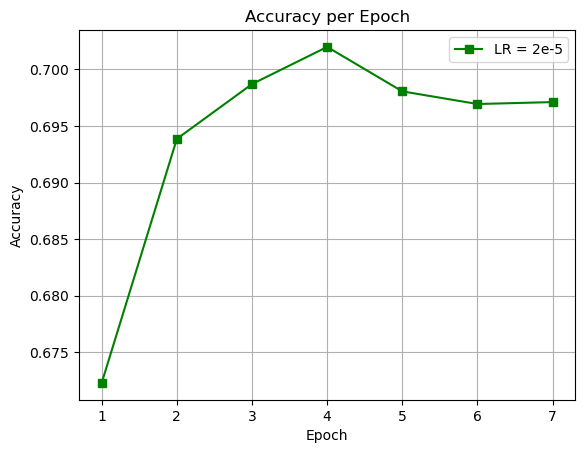

In [8]:
import matplotlib.pyplot as plt

epochs = range(1, len(test_accuarcy)+1)

plt.plot(epochs, test_accuarcy, marker='s', linestyle='-', color='green', label='LR = 2e-5')

plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend()
plt.grid(True)

plt.show()